### <center>Salim LOUCIF</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio,display

#Normalisation d'un signal
def normaliser(x):
    return (x-np.mean(x))/np.std(x)

#Filtre de préaccentuation
def preaccentuation(x):
    return x[:-1]-0.97*x[1:]

#Fenêtre de hamming
def hamming(T):
    t=np.arange(T) #t=0..T-1
    return 0.54-0.46*np.cos(2*np.pi*t/(T-1))

#Calcul du spectre amplitude et phase du signal x, taille de la fenetre=T, pas=p
#mettre pre=True dans l'appel pour activer la préaccentuation
#mettre win=hamming(T) pour activer le fenêtrage par hamming
#Tfft=taille de la fft, si > T le zéro padding sera activé(voir cours acoustique)
def spectrogram(x,T,p,Tfft=None,pre=False,wind=None):
    if pre:
        x=preaccentuation(x)
        
    n=len(x) #taille de x
    S=[] 
    
    #début fenêtrage
    for i in range(0,n-T,p):
        xt=x[i:i+T]
        if not wind is None:
            xt=xt*wind
        S.append(xt)
    
    #Transformée de Fourier        
    if Tfft is None: Tfft=T
    S=np.fft.fft(S,Tfft)
    amp=np.abs(S) #spectre d'amplitude
    #print('AMP ---> ',amp)
    phase=np.angle(S) #spectre de phase
    
    return amp,phase


#Retour du domaine fréquentiel au domaine temporel à partir de l'amplitude et la phase et le "pas" utilisé
#Ne pas utiliser la préaccentuation si vous voulez utiliser cette fonction
def reconstituer(amp,phase,p):
    n,w = amp.shape
    duree=(n-1)*p+w  #estimation de la durée du signal selon le pas et le nombre de fenêtres
    signal=np.zeros(duree)  #initialiser le signal par des zéros 
    trams=np.zeros(duree)  #initialiser le nombre de trames par des zéros 
    
    temp=amp*np.exp(1j*phase) #recombiner l'amplitude avec la phase (nombre complexe)
    temp=np.fft.ifft(temp) #retour au domaine temporel par une fft inverse
    temp=np.real(temp) #ne garder que la partie réel
    
    #fenêtrage inverse
    for i in range(n):
        signal[i*p:i*p+w]+=temp[i,:]
        trams[i*p:i*p+w]+=1

    signal=signal/trams  #calculer la moyenne du signal à partir des fenêtres qui se recouvrent
    return signal


#Cette fonction affiche un spectrogramme d'amplitude S
#fs: fréquence d'échantillonnage du signal, duree: durée du signal en secondes
#log: afficher le log du spectre 
def affich(S,fs,duree,log=True,maxfreq=None):
    (n,m)=S.shape #Nombre de lignes et colonnes de la matrice du spectre
    if maxfreq is None:
        maxfreq=fs/2 #couper le spectre en 2 (effet mirroir)
    
    maxindice=int(maxfreq*m/fs) #convertir maxfreq de Hz à indice
    
    if(log):
        S=np.log10(abs(S)+1) #calcul du log pour l'affichage
    
    S=S[:,:maxindice] #couper le spectre en frequence max
    
    freq=np.linspace(0, maxfreq, maxindice) #labels de l'axe des fréquences
    temps=np.linspace(0, duree,n) #labels de l'axe du temps
    
    plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes
    plt.ylabel('Fréquence (Hz)')
    plt.xlabel('Temps (sec)')
    plt.grid()
    plt.show()
    
    
##Cette fonction calcule l'énergie du signal
def energy(data, T, p):
    amp,phase=spectrogram(data,T,p)   #passage au domaine fréquentiel
    e=np.mean(amp**2,axis=1) #calcul de la moyenne des amplitudes au carée
    return e


In [2]:
#chargement d'un fichier audio avec bruit
wav='C:\\f5_bruit2.wav'
fs, data = wavfile.read(wav) #fs: fréquence d'échantillonnage 
print(len(data))
data=normaliser(data) #normaliser le signal 
print(len(data))
duree=len(data)/fs   #durée du signal en secondes
print('Frequence d\'échantillonnage:',fs,'Hz, durée:',duree,'sec')
display(Audio(data,rate=fs))

58360
58360
Frequence d'échantillonnage: 22050 Hz, durée: 2.6467120181405894 sec


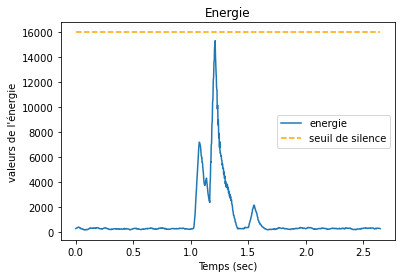

<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes


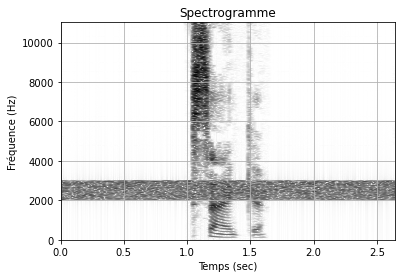

(58360,)


In [11]:
####################### Affichage du spectrogramme et de l'énergie ##############################
T=1024
p=32

E=energy(data, T, p) #calcule de l'énergie
seuil=16000

#dessin de l'énergie
plt.title('Energie')
plt.plot(np.linspace(0, duree, len(E)),E) #affichage de l'énergie
plt.plot([0,duree],[seuil,seuil],color='orange',linestyle='dashed') #dessiner le seuil
plt.ylabel('valeurs de l\'énergie')
plt.xlabel('Temps (sec)')
plt.legend(['energie','seuil de silence'])
plt.show()


amp,phase=spectrogram(data,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme
print(data.shape)

On remarque une bande de bruit localisée entre 2000 et 3000Hz à partir du spectrogramme. On peut utiliser un filtre passe bandes pour réduire ce bruit.


### Filtre passe bandes

<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes


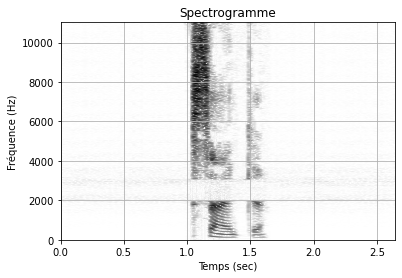

In [12]:
#ce filtre permet de réduire l'énergie des fréquences dans l'intervalle [minfreq, maxfreq]
#pour un signal data de fréquence d'échantillonage fs en multipliant par alpha dans [0, 1]
def filtre_bandes(data, fs, minfreq, maxfreq, alpha):
    assert alpha>=0 and alpha<=1, "alpha doit être compris dans [0, 1]"
    assert minfreq>=0 and minfreq<=(fs/2), "minfreq doit être compris dans [0, %d]"%(fs/2)
    assert maxfreq>=0 and maxfreq<=(fs/2), "maxfreq doit être compris dans [0, %d]"%(fs/2)

    T=1024  #choisir une taille de fenêtre
    p=32   #choisir un pas
    minId=int(minfreq*T/fs)  #convertir les fréquences en indices
    maxId=int(maxfreq*T/fs)
    
    amp,phase=spectrogram(data,T,p)  #passage au fréquentiel
    amp[:,int(T/2):]=0; amp=2*amp  #éliminer l'effet miroir pour ne pas filtrer 2 fois
    amp[:,minId:maxId]=amp[:,minId:maxId]*alpha #multiplier la bande choisite par alpha

    return reconstituer(amp,phase,p) #retour au temporel
    
    
#################### Filtrage du signal de parole ###########################################    
data_sansbruit=filtre_bandes(data, fs, 2000, 3100, 0) #filtrer le signal entre 2000 et 3100Hz

amp,phase=spectrogram(data_sansbruit,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme

display(Audio(data_sansbruit,rate=fs))

(1792,)
(1791, 1024)
(0, 1024)
(1024,)
[nan nan nan ... nan nan nan]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dt

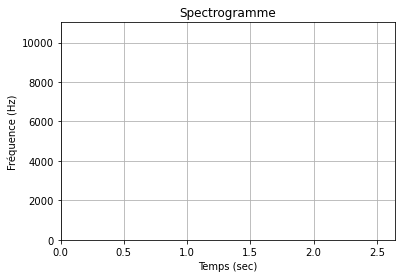

In [14]:
print(E.shape)

print(amp.shape)
S = amp[E[:1791]>=seuil]
print(S.shape)

noise_profile = []
noise_profile = np.mean(S,axis = 0)

print(noise_profile.shape)
print(noise_profile)

new_amp = amp - (1*noise_profile)
#print(new_amp)
np.where(new_amp<0,0,new_amp)

data_sansbruit=reconstituer(new_amp,phase,p)
amp,phase=spectrogram(data_sansbruit,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme

display(Audio(data_sansbruit,rate=fs))

##### Question:
Donnez des remarques détaillées sur cette expérience

#### Answer:

- I see that using the "filter pass bas" eliminates all the sound in that interval from 2000 Hz to 3100 Hz even the sound of the word "cinq"

- It can't remove only the noise because it's not an addition between two sounds, it's a noise that can be located by frequency analysis if it detected in all frequencies it's hard to remove it all without touching the original sound

- I see that when we set alpha to 0, all the sound in that interval will be eliminated (amplitude = 0) and if we increase alpha the amplitude in that interval will increase, so we used alpha = 0 to remove all the sound in that interval and make the noise unheard

- we didn't use "seuill" because in this filter it's not necessarily, we are removing the noise by interval, however, if used "bruit stationnaire additif" we do use "seuill" and it will remove all amplitudes below it so if the noise has higher amplitude in the sound then all the sound will get removed

In [5]:
#chargement d'un fichier audio avec bruit
wav='C:\\f5_bruit.wav'
fs, data = wavfile.read(wav) #fs: fréquence d'échantillonnage 
data=normaliser(data) #normaliser le signal 
print(len(data))
duree=len(data)/fs   #durée du signal en secondes
print('Frequence d\'échantillonnage:',fs,'Hz, durée:',duree,'sec')
display(Audio(data,rate=fs))

66150
Frequence d'échantillonnage: 22050 Hz, durée: 3.0 sec


66150


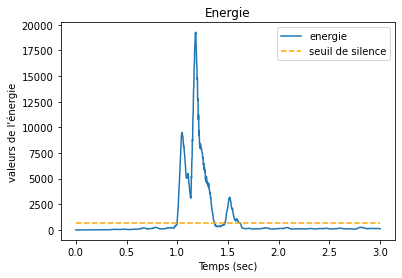

<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes


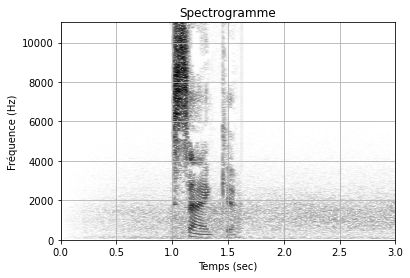

In [6]:
####################### Affichage du spectrogramme et de l'énergie ##############################
T=1024
p=32

E=energy(data, T, p) #calcule de l'énergie
seuil=700  #on choisit une valeur pour le seuil, si energie < seuil -> silence
print(len(data))
#dessin de l'énergie
plt.title('Energie')
plt.plot(np.linspace(0, duree, len(E)),E) #affichage de l'énergie
plt.plot([0,duree],[seuil,seuil],color='orange',linestyle='dashed') #dessiner le seuil
plt.ylabel('valeurs de l\'énergie')
plt.xlabel('Temps (sec)')
plt.legend(['energie','seuil de silence'])
plt.show()


amp,phase=spectrogram(data,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme

In [7]:
#print(amp[:10,:10]<=4)
noise_amp = []
#print(amp)

print(amp.shape)
S = amp[E<=seuil]
print(S.shape)

noise_profile = []
noise_profile = np.mean(S,axis = 0)

print(noise_profile.shape)
print(noise_profile)

(2036, 1024)
(1690, 1024)
(1024,)
[0.03924287 0.13337484 0.54953184 ... 1.3131014  0.54953184 0.13337484]


In [8]:
new_amp = amp - (1*noise_profile)
#print(new_amp)
np.where(new_amp<0,0,new_amp)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.21277522, 0.52905384, ..., 0.        , 0.52905384,
        0.21277522],
       [0.        , 0.2522814 , 0.47049744, ..., 0.        , 0.47049744,
        0.2522814 ],
       [0.        , 0.19483544, 0.48901905, ..., 0.        , 0.48901905,
        0.19483544]])

<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes


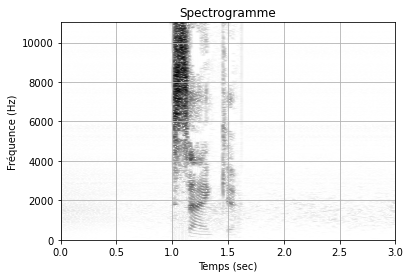

In [9]:
data_sansbruit=reconstituer(new_amp,phase,p)
amp,phase=spectrogram(data_sansbruit,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme

display(Audio(data_sansbruit,rate=fs))

- In this experience, I see that the additive stationary noise "bruit stationnaire additif" can be removed easily without touching the original sound using the spectral subtraction method " la méthode de soustraction spectrale " because the two sounds are not merged just one above one so it can be removed by subtraction

<ipython-input-1-c4cf2d5ff19c>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(temps, freq, S.T, cmap='gray_r')  #afficher le spectre sans correction des axes


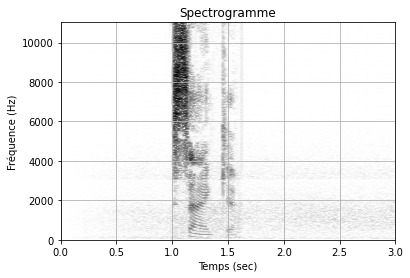

In [13]:
data_sansbruit=filtre_bandes(data, fs, 0, 3100, 0.2) #filtrer le signal entre 2000 et 3100Hz

amp,phase=spectrogram(data_sansbruit,T,p,pre=True,wind=hamming(T))  #calcul du spectrogramme
plt.title('Spectrogramme')
affich(amp,fs,duree) #affichage du spectrogrammme

display(Audio(data_sansbruit,rate=fs))

- I see that using "filter pass bas"  in an additive stationary noise not a good way, beacause you can't exactly specify the noise by numbers .. the noise is little everywhere soo it will not remove it efficiently and all, however, the sound quality of the "cinq" is better when you use this filter better than  the spectral subtraction method not only in this type of noise in the noise too 
- here we used the "sueil" to remove all the amplitude below it so as long as you increase the "sueil" the sound will get removed not only the noise
- I think that "sueil" allows you to take a big piece of a silent part that you assume it is, and then alpha amplifies this part to remove higher amplitudes from the sound